<a href="https://colab.research.google.com/github/junaiskv94/Online-retail-segmentaion/blob/main/Capstone4_Online_retail_segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Importing required libraries
import numpy as np
# To handle the dataset
import pandas as pd

# For plots and visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
from yellowbrick.cluster import SilhouetteVisualizer

# For getting optimal number of clusters in hierarchical clustering
from scipy.cluster.hierarchy import dendrogram,linkage
# To scale the data
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer
# metrics to evaluate the clusters
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score,silhouette_samples
# Clustering alorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# Display utilities
from IPython.display import Markdown, display
from datetime import datetime

# activating DND to disregard the warnings by goiing silent mode
import warnings
warnings.filterwarnings('ignore')

# setting default parameters for the plots
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["figure.dpi"] = 150

In [2]:

#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#Reading the data
cus_data = pd.read_csv('/content/drive/MyDrive/capstone_project/4-Online retail segmentaion/Online Retail.xlsx - Online Retail.csv')

**Preliminary Data Inspection**

In [4]:
#First 5 observations of the dataframe
cus_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [5]:
# check for rows and columns
cus_data.shape

(541909, 8)

In [6]:

# summary of the dataset
cus_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:

#A statistical description of the numerical features of dataset
cus_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
# Checking number of unique values in each column
for col in cus_data.columns:
  print(col,':',cus_data[col].nunique())


InvoiceNo : 25900
StockCode : 4070
Description : 4223
Quantity : 722
InvoiceDate : 23260
UnitPrice : 1630
CustomerID : 4372
Country : 38


In [9]:
#Check for null values
cus_data.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
# Missing data counts and percentage
missing = cus_data.columns[cus_data.isnull().any()].tolist()
print('Missing Data Percentage')
print(round(cus_data[missing].isnull().sum().sort_values(ascending = False)/len(cus_data)*100,2))

Missing Data Percentage
CustomerID     24.93
Description     0.27
dtype: float64




*   24.93% of items purchases are not assigned to any customer
*   So there is no use of having the data with no customer assignment.\
 we can't form clusters without CustomerID so we will delete them from dataset.

In [11]:
#Dropping the null values in the dataset
cus_data.dropna(subset=['CustomerID'],inplace=True)

In [12]:
# cross check null values after removing
cus_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
#Deleting the duplicate values from the data
print('Duplicate entries: {}'.format(cus_data.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((cus_data.duplicated().sum()/cus_data.shape[0])*100),2))
cus_data.drop_duplicates(inplace = True)

Duplicate entries: 5225
1% rows are duplicate.


In [14]:
#cross Check for duplicate values
cus_data.duplicated().sum()

0

descriptive analytics on the given data

In [15]:
# Checking the total number of products, transactions and customers.
pd.DataFrame([{'products': len(cus_data['StockCode'].value_counts()),    
               'transactions': len(cus_data['InvoiceNo'].value_counts()),
               'customers': len(cus_data['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [16]:
# country with most customer
cus_data.Country.value_counts(normalize=True).head(10).mul(100).round(2).astype(str) + ' %'

United Kingdom    88.83 %
Germany            2.36 %
France             2.11 %
EIRE               1.86 %
Spain              0.63 %
Netherlands        0.59 %
Belgium            0.52 %
Switzerland        0.47 %
Portugal           0.37 %
Australia          0.31 %
Name: Country, dtype: object

In [17]:
# check for columnns

cus_data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [18]:
#list of columns that can contain outliers
out_cols = ['Quantity','UnitPrice']

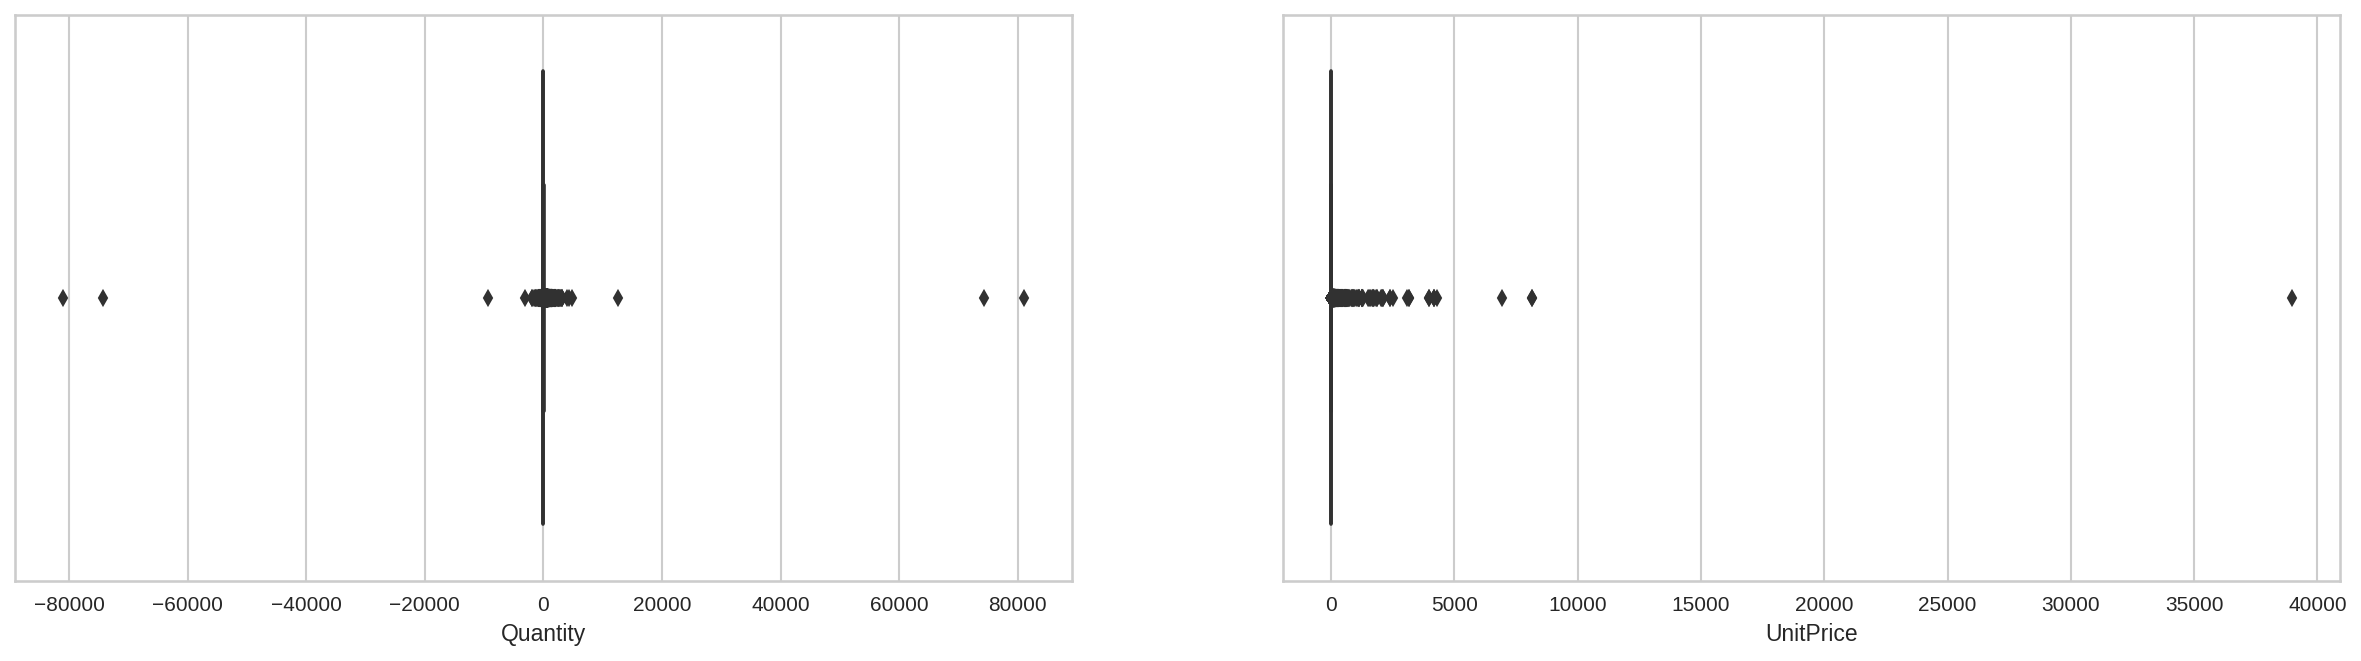

In [19]:
#Checking for outliers in the data      
for index, col in enumerate(out_cols):
  plt.subplot(1,2,index+1)
  sns.boxplot(data = cus_data,x=col)

The negative quanity represent the cancelled orders

**Feature Engineering**

In [20]:

#Finding the cancelled orders: InvoiceNo starting with 'C' represents cancellation
cus_data['InvoiceNo'] = cus_data['InvoiceNo'].astype('str') #change data typpe tp str
cancellations = cus_data[cus_data['InvoiceNo'].str.contains('C')]  #find rows contains 'C'
cancellations.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/10 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/10 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/10 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom


In [21]:
cancellations.shape

(8872, 8)

In [22]:
# Check for NaN values
cancellations.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [23]:
# # Dropping cancellations from the main dataframe
dataset = cus_data[~cus_data.isin(cancellations)].dropna(how='all')

In [24]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/10 8:26,3.39,17850.0,United Kingdom


In [25]:
dataset.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,12/9/11 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,12/9/11 12:50,4.95,12680.0,France


In [26]:
dataset.shape

(392732, 8)

Extract columns from the InvoiceDate column:

In [27]:
# convert InvoiveDate to datetime 
dataset["InvoiceDate"]=dataset["InvoiceDate"].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))

In [28]:
# Check for date range of data
all_dates = (pd.to_datetime(cus_data['InvoiceDate'])).apply(lambda x:x.date())
(all_dates.max() - all_dates.min()).days

In [30]:
# Start and end dates:
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-01
End date: 2011-12-09


In [31]:
# Creating new features from the datetime column InvoiceDate
dataset["year"]  = dataset["InvoiceDate"].apply(lambda x: x.year)
dataset['Month'] = dataset['InvoiceDate'].apply(lambda x: x.month_name())
dataset['Day']   = dataset['InvoiceDate'].apply(lambda x: x.day_name())
dataset["hour"]  = dataset["InvoiceDate"].apply(lambda x: x.hour)


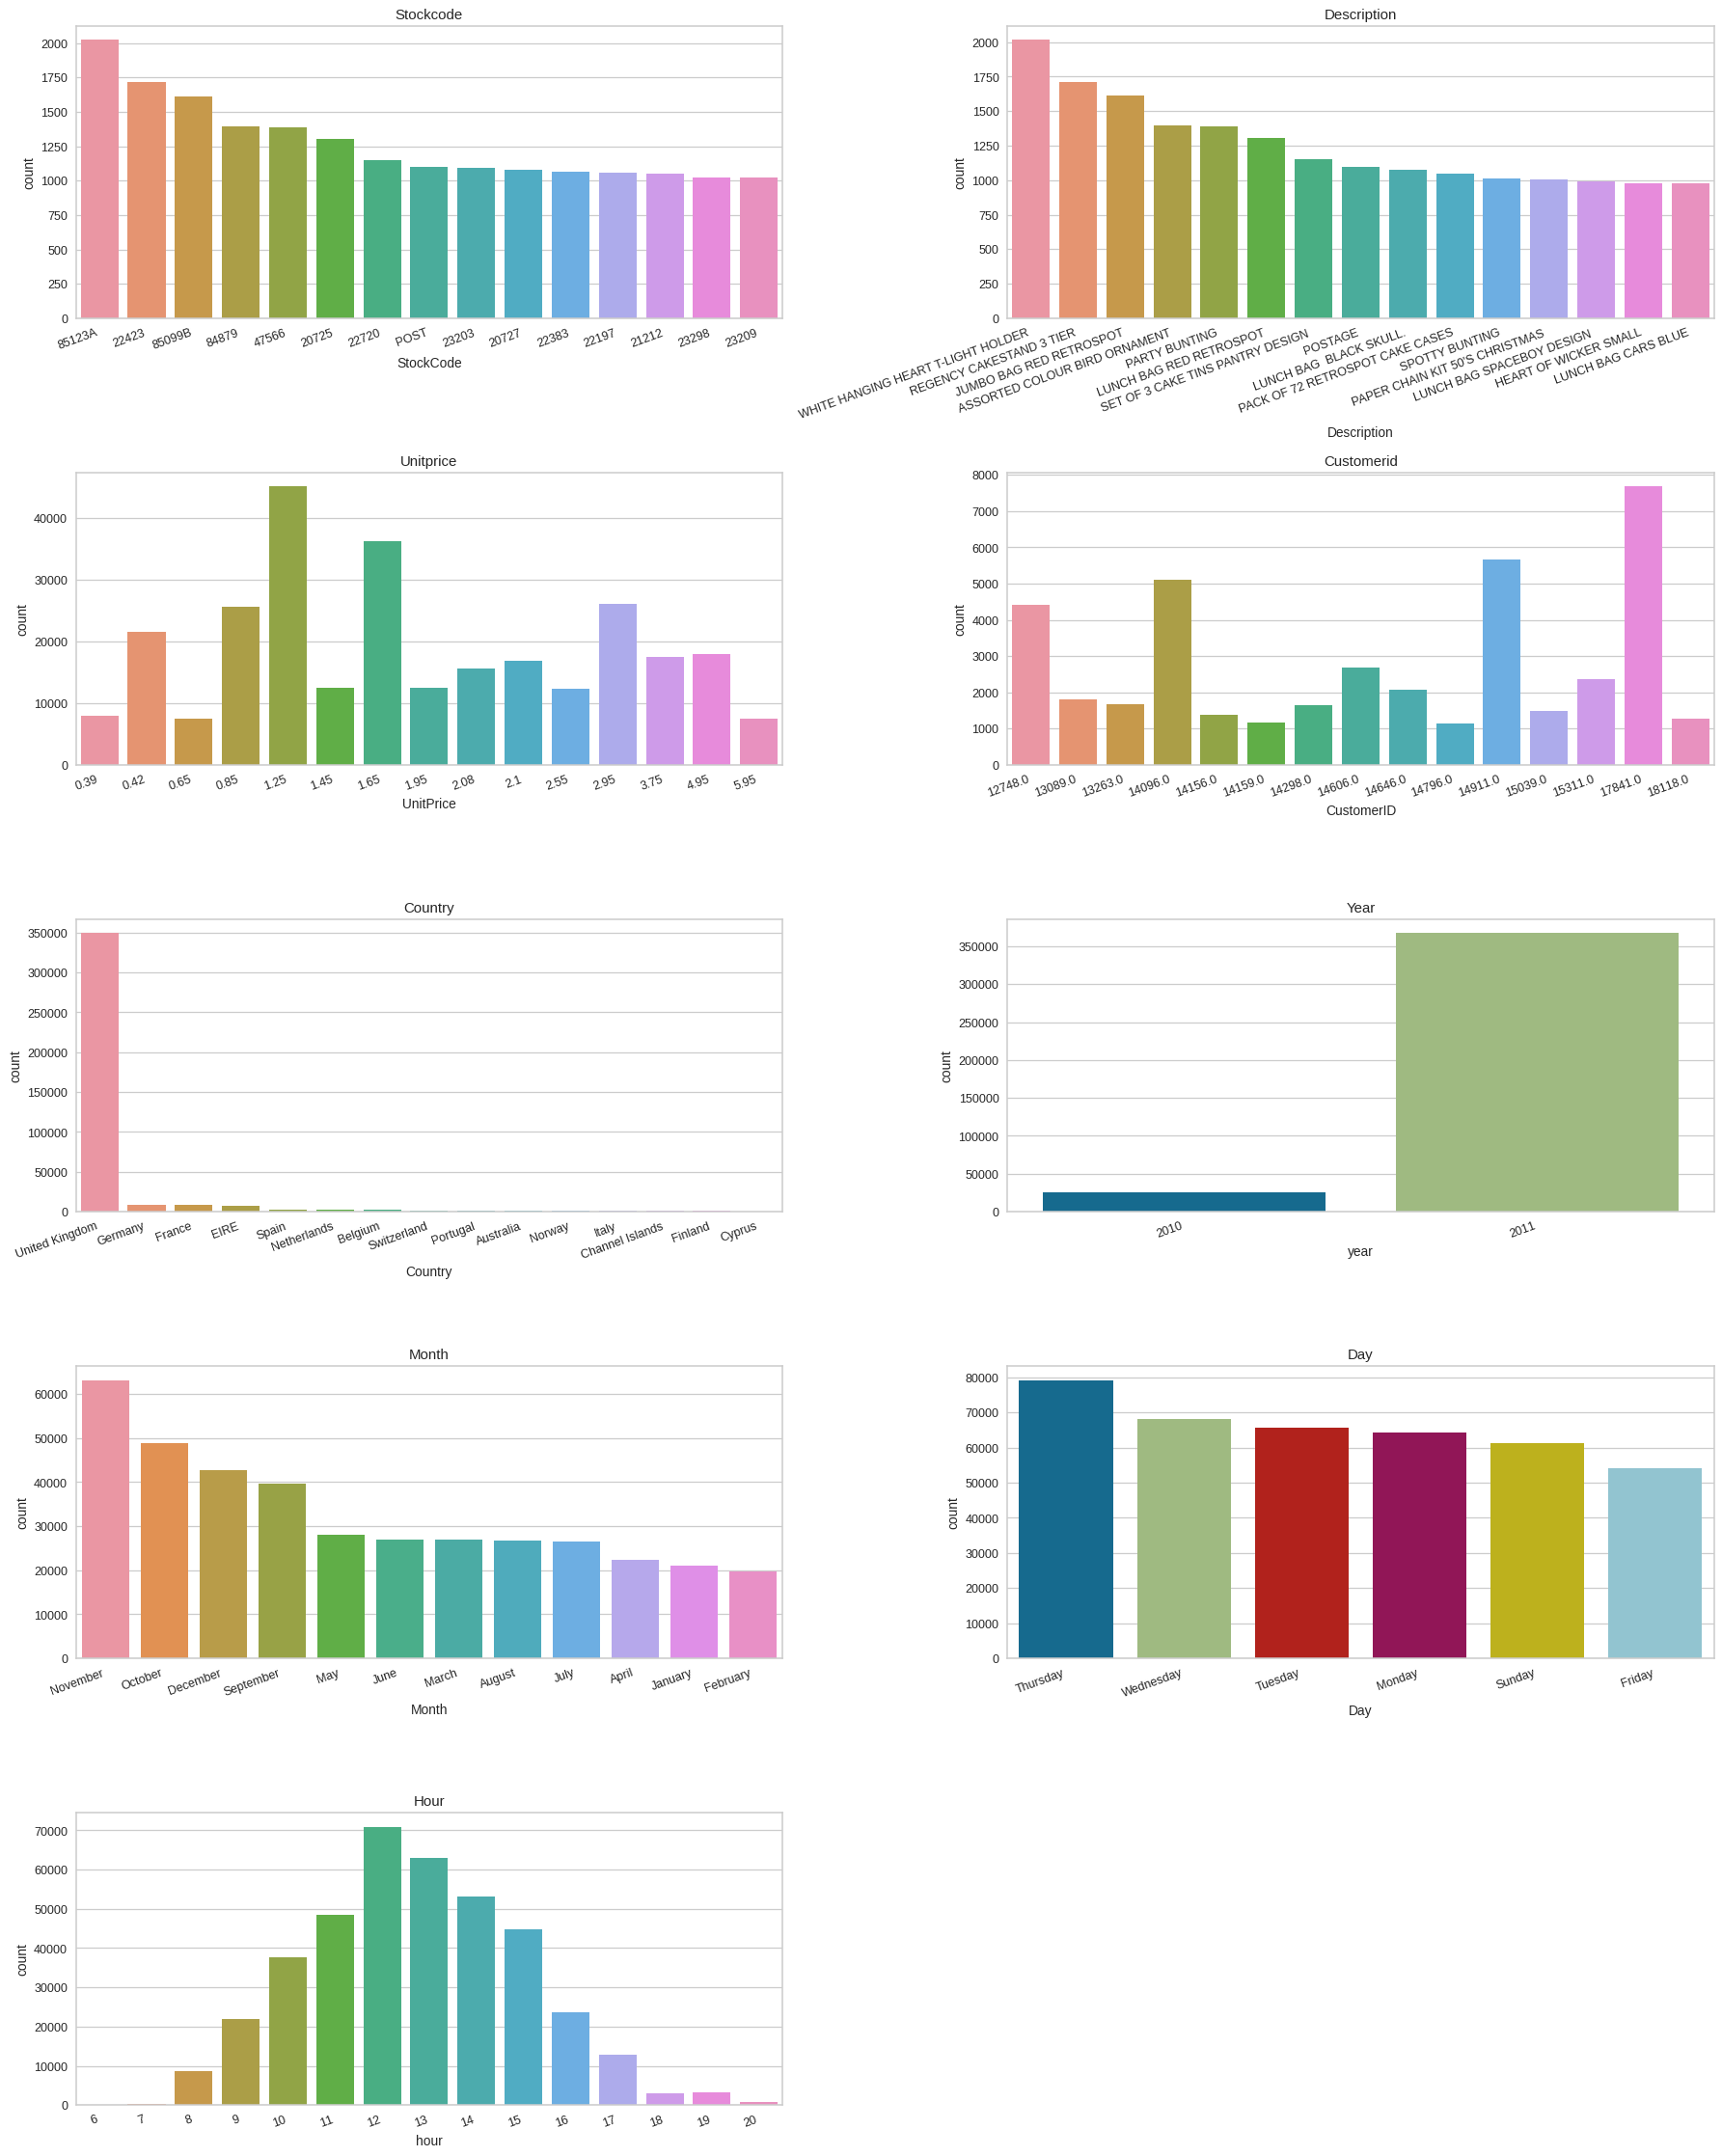

In [32]:
# Plotting top values based on frequency in each column
target = ['StockCode', 'Description','UnitPrice', 'CustomerID', 'Country',
          'year', 'Month','Day','hour']

plt.figure(figsize=(20,25), dpi=90)
for n,col in enumerate(target):
  plt.subplot(5, 2, n+1)
  temp = dataset[col].value_counts().reset_index().head(15)
  temp.rename(columns={'index': col, col:'count'}, inplace=True)
  sns.barplot(x=col ,y='count', data=temp).set(title=col.title())
  plt.xticks(rotation=20,ha='right')
  plt.tight_layout()

Observations/Hypothesis:

Most Customers are from United Kingdom. Considerable number of customers are also from Germany, France, EIRE and Spain. Whereas Saudi Arabia, Bahrain, Czech Republic, Brazil and Lithuania has least number of customers\
There are no orders placed on Saturdays. Looks like it's a non working day for the retailer.\
Most of the customers have purchased the gifts in the month of November, October, December and September. Less number of customers have purchased the gifts in the month of April, January and February.\
Most of the customers have purchased the items in Afternoon, moderate numbers of customers have purchased the items in Morning and the least in Evening.\
WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, JUMBO BAG RED RETROSPOT are the most ordered products

In [33]:
#Creating a list of all the numerical columns in the data
numerical_columns = list(dataset.describe().columns)
numerical_columns


['Quantity', 'UnitPrice', 'CustomerID', 'year', 'hour']

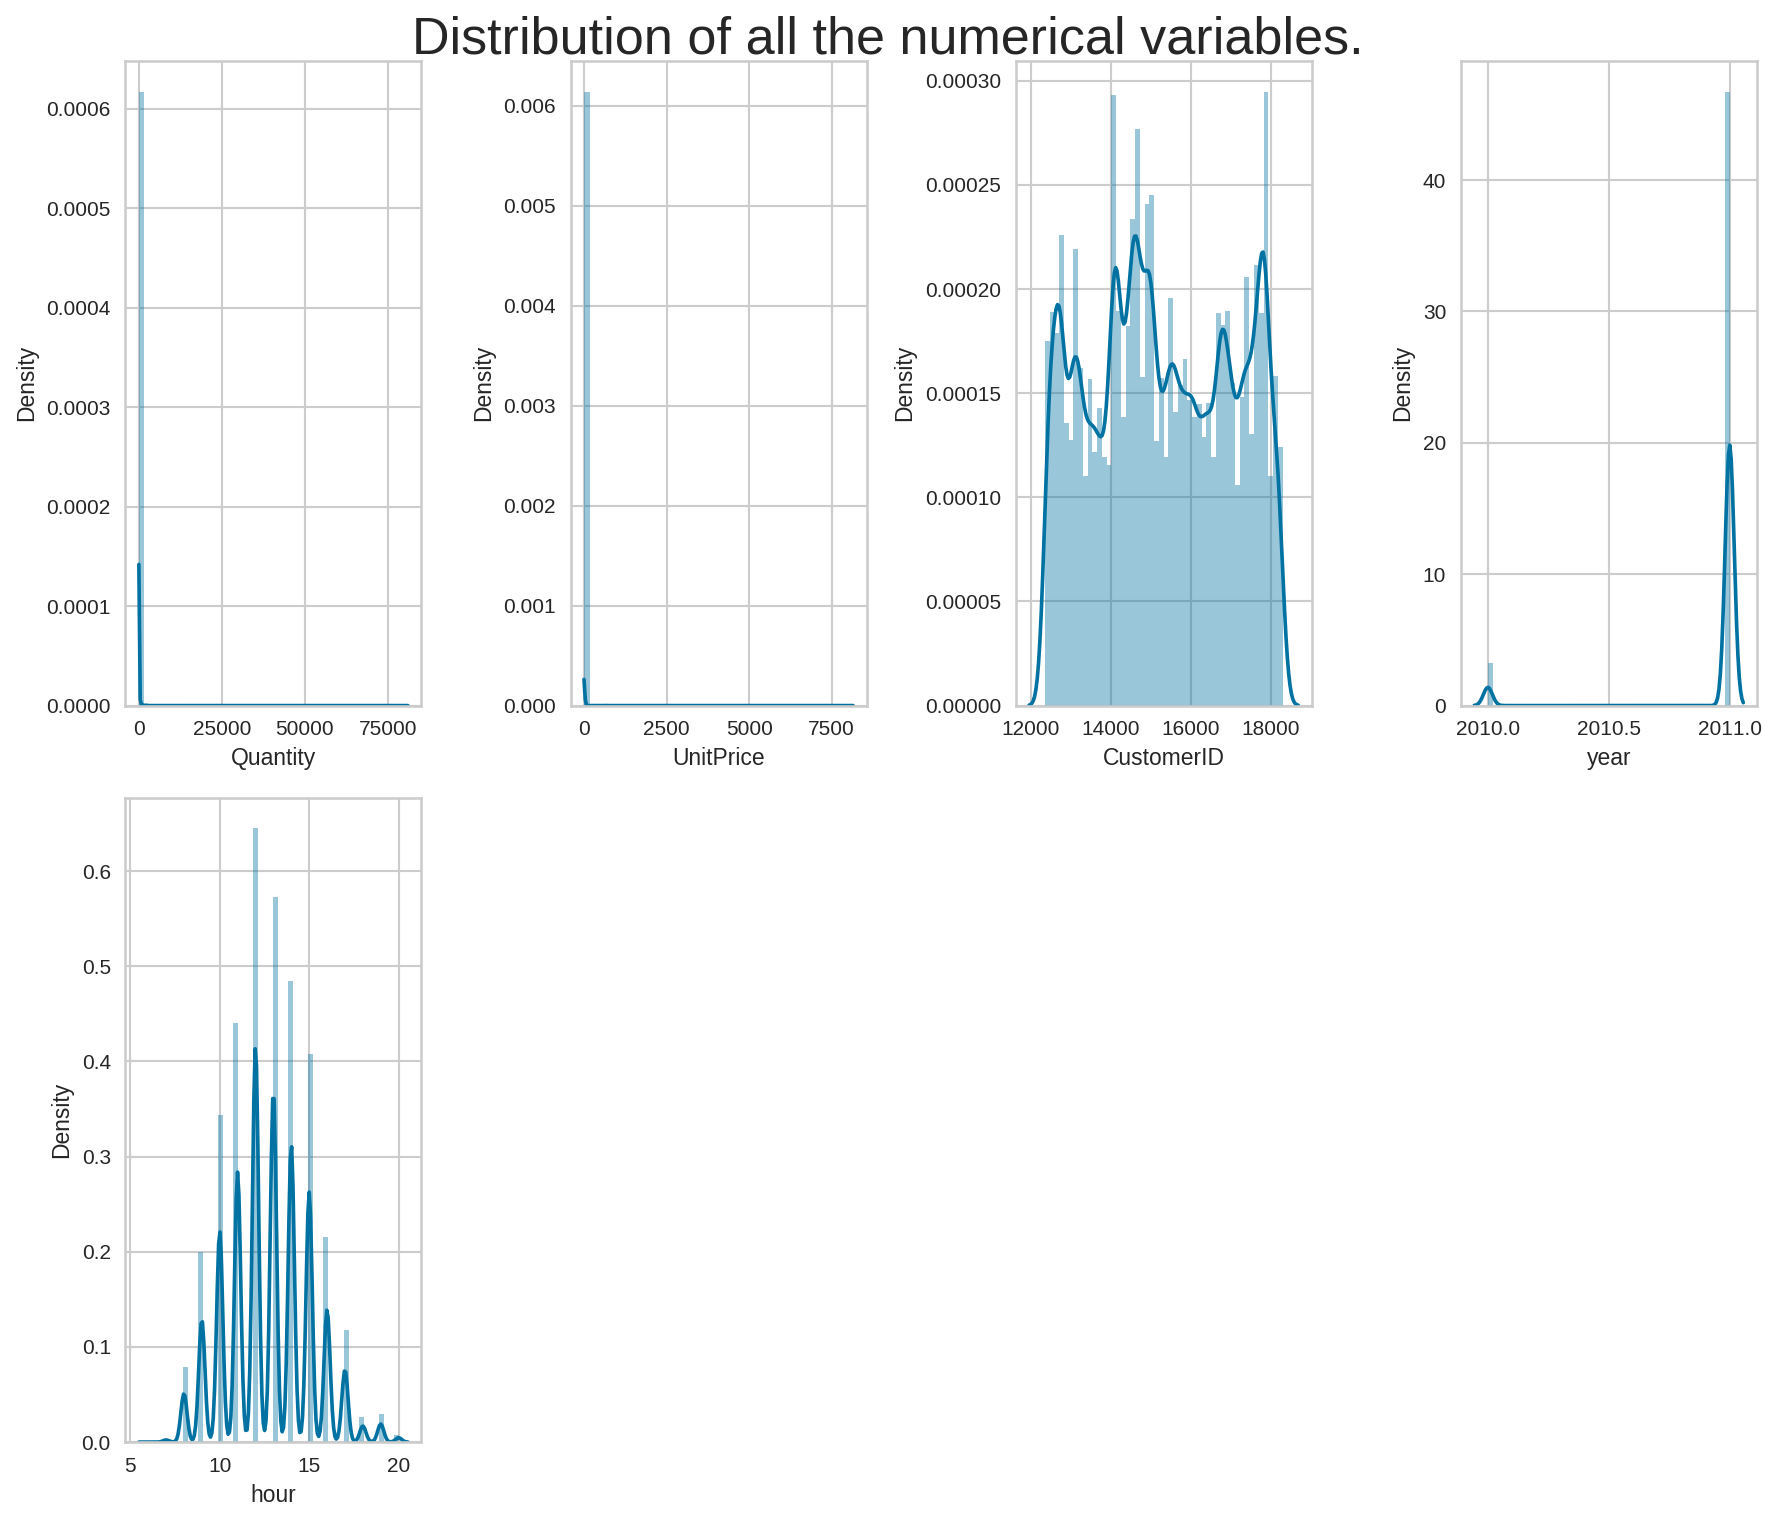

In [34]:
#Plotting the distribution of the data
plt.figure(figsize=(12,10))
plt.suptitle('Distribution of all the numerical variables.',va='bottom',size=25)
for index, item in enumerate(numerical_columns):
  plt.subplot(2,4,index+1)
  sns.distplot(dataset[item])
plt.tight_layout()


It shows a positively skewed distribution because most of the values are clustered around the left side of the distribution while the right tail of the distribution is longer, which means mean>median>mode
For symmetric graph mean=median=mode.

In [35]:

# Creating a new feature 'TotalAmount' by multiplying Quantity and UnitPrice
dataset['TotalAmount'] = dataset['Quantity']*dataset['UnitPrice']


In [36]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,Month,Day,hour,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,December,Wednesday,8,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,December,Wednesday,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8,20.34


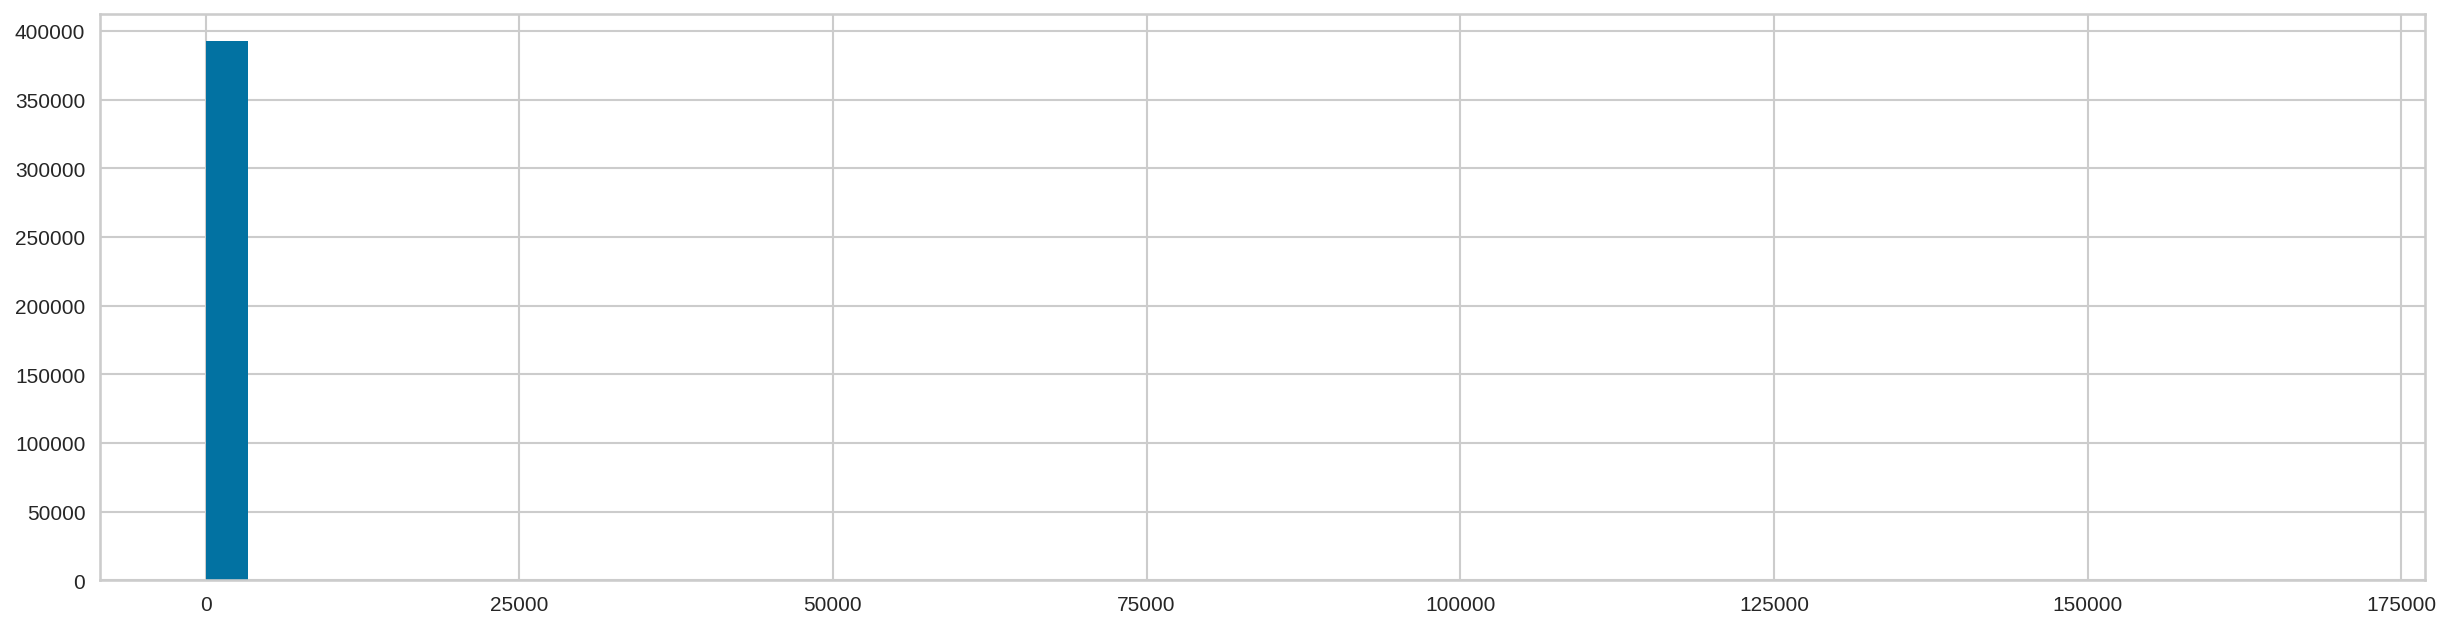

In [37]:
# Let us check the distribution of the TotalAmount column to understand customer spending
dataset.TotalAmount.hist(bins=50)

In [38]:
dataset[['TotalAmount']].describe()

,TotalAmount
count,392732.000000
mean,22.629195
std,311.083465
min,0.000000
25%,4.950000
50%,12.390000
75%,19.800000
max,168469.600000


TotalAmount values in the Top 25% of our data increase very rapidly from 19.8 
to 168,469

In [39]:
# Check for the max amount orders
dataset[dataset['TotalAmount']> 19.800000].sort_values('TotalAmount',ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,Month,Day,hour,TotalAmount
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995.0,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011,December,Friday,9,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011,January,Tuesday,10,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60.0,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,2011,June,Friday,15,38970.00
173382,551697,POST,POSTAGE,1.0,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,2011,May,Tuesday,13,8142.75
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412.0,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,2011,September,Tuesday,11,7144.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
467169,576339,22591,CARDHOLDER GINGHAM CHRISTMAS TREE,3.0,2011-11-14 15:27:00,6.63,14096.0,United Kingdom,2011,November,Monday,15,19.89
466932,576339,21035,SET/2 RED RETROSPOT TEA TOWELS,3.0,2011-11-14 15:27:00,6.63,14096.0,United Kingdom,2011,November,Monday,15,19.89
466905,576339,20682,RED RETROSPOT CHILDRENS UMBRELLA,3.0,2011-11-14 15:27:00,6.63,14096.0,United Kingdom,2011,November,Monday,15,19.89
439113,574355,23403,LETTER HOLDER HOME SWEET HOME,8.0,2011-11-04 10:48:00,2.48,18102.0,United Kingdom,2011,November,Friday,10,19.84


Plotting the correlation matrix:

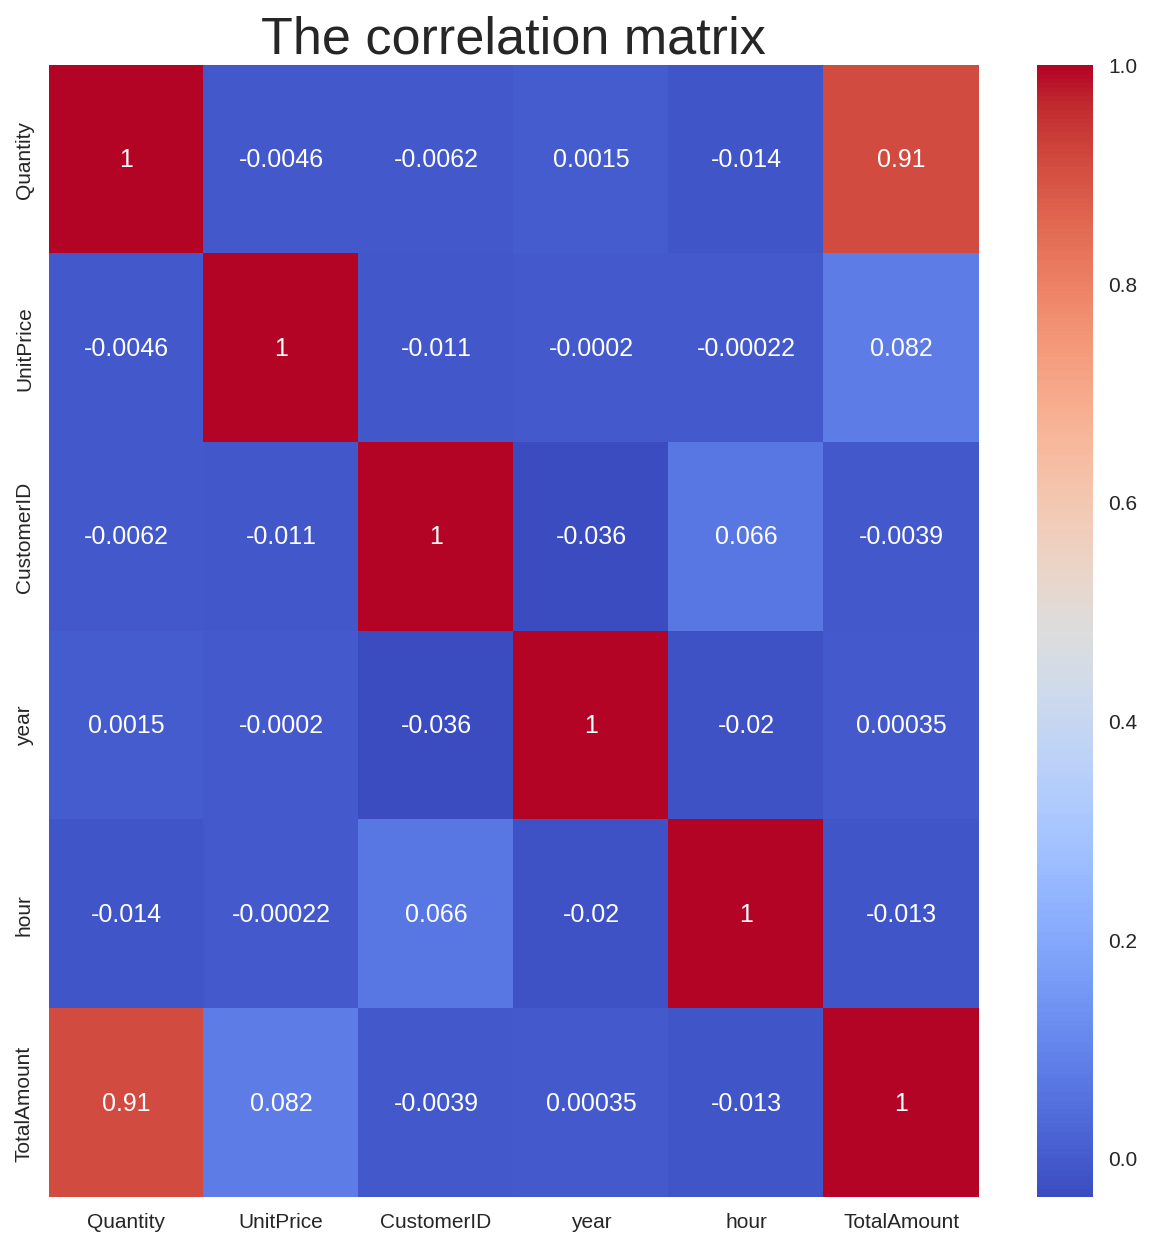

In [40]:
#Forming and plotting the correlation matrix
corr_matrix = dataset.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.title('The correlation matrix',size=25)
plt.show()

There is no distinct correlation between the variables except for the columns 'total_amount', 'Quantity' and 'UnitPrice', which is obivious

**segmentation criteria:**

we need to cluster customers according to there activities i.e


1.   R- Recency
2.   F- Frequency
3.   M- Monetary









In [41]:
#Creating a variable to hold the latest date in the dataset
latest_date = dataset['InvoiceDate'].max()+ pd.DateOffset(days=1)

In [42]:
#Creating a dataframe to contain the most recent date of order for each customer
recency_df = dataset.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df.head()


,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [43]:

#creating a dataframe to contain the number of times a customer has ordered
frequency_df = dataset.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency_df.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [44]:
#creating a dataframe to contain the total spends of a customer
monetory_df = dataset.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetory_df.head()

,CustomerID,TotalAmount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Interpretation:

Recency: How recent a customer made a purchase.\
Frequency: How often a customer makes a purchase.\
Monetary: How much money a customer spends.

In [45]:

#Creating a dataframe for the RFM model
rfm_df = pd.DataFrame()
rfm_df['CustomerID'] = recency_df['CustomerID']
rfm_df['Recency'] = recency_df['InvoiceDate'].apply(lambda x: (latest_date-x).days)
rfm_df['Frequency'] = frequency_df['InvoiceNo']
rfm_df['Monetary'] = monetory_df['TotalAmount']

In [46]:

#Setting the CustomerID as the index
rfm_df.set_index('CustomerID',inplace=True)

#First 10 observations of the RFM dataframe
rfm_df.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
12352.0,36,85,2506.04
12353.0,204,4,89.00
12354.0,232,58,1079.40
12355.0,214,13,459.40


create ‘quartiles’ on each of the metrics and assigning the required order

In [47]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(rfm_df['Recency'], 4, labels = r_labels)
rfm_df = rfm_df.assign(R = r_quartiles.values)

f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(rfm_df['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(rfm_df['Monetary'], 4, labels = m_labels)
rfm_df = rfm_df.assign(F = f_quartiles.values)
rfm_df = rfm_df.assign(M = m_quartiles.values)
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


collate these scores into an RFM_Segment column. The RFM_Score is calculated by summing up the RFM quartile metrics

In [48]:
def join_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int((x['M'])))

rfm_df['RFM_Segment'] = rfm_df.apply(join_rfm, axis=1)
rfm_df['RFM_Score'] = rfm_df[['R','F','M']].sum(axis=1)
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


analyse RFM Score distribution and their groups.

In [49]:
rfm_df.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           260.7       8.2    157.4   381
4           177.2      13.6    240.0   388
5           152.9      21.2    366.6   518
6            95.9      27.8    820.1   457
7            79.4      37.9    757.1   464
8            64.1      56.0    987.3   454
9            45.9      78.7   1795.1   414
10           32.4     110.5   2056.4   426
11           21.3     186.9   4062.0   387
12            7.2     367.9   9285.9   450

create segments within this score range of RFM_Score 3–12, by manually creating categories in our data

In [50]:
# Assign Loyelty Level to each customer
Loyalty_Level = ['Bronz','Silver','Gold','Platinaum']

Score_cut = pd.qcut(rfm_df['RFM_Score'],q = 4,labels=Loyalty_Level)
rfm_df['RFM_Loyalty_Level'] = Score_cut.values
rfm_df.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Loyalty_Level
0,12346.0,326,1,77183.60,1,1,4,114,6,Silver
1,12347.0,2,182,4310.00,4,4,4,444,12,Platinaum
2,12348.0,75,31,1797.24,2,2,4,224,8,Gold
3,12349.0,19,73,1757.55,3,3,4,334,10,Gold
4,12350.0,310,17,334.40,1,1,2,112,4,Bronz


In [51]:
rfm_df.groupby('RFM_Loyalty_Level').agg({'Recency': ['mean','min','max'],
                                         'Frequency': ['mean','min','max'],
                                         'Monetary': ['mean','min','max', 'count']}).round(1)

Recency          Frequency           Monetary         \
                     mean min  max      mean min   max     mean    min   
RFM_Loyalty_Level                                                        
Bronz               192.2  19  374      15.1   1    84    266.5    3.8   
Silver               87.6   1  374      32.9   1   123    788.4    0.0   
Gold                 47.8   1  372      81.2   1   521   1597.7  120.0   
Platinaum            13.8   1   51     284.2  43  7676   6870.5  674.8   

                                   
                        max count  
RFM_Loyalty_Level                  
Bronz                1542.1  1287  
Silver              77183.6   921  
Gold               168472.5  1294  
Platinaum          280206.0   837

In [52]:

# Validate the data For RFM group = 111
rfm_df[rfm_df['RFM_Segment'] == '111'].sort_values("Monetary",ascending = False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Loyalty_Level
0,17176.0,202,15,306.13,1,1,1,111,3,Bronz
1,15219.0,176,9,305.75,1,1,1,111,3,Bronz
2,18220.0,227,2,305.28,1,1,1,111,3,Bronz
3,18185.0,249,17,304.25,1,1,1,111,3,Bronz
4,16217.0,235,15,304.25,1,1,1,111,3,Bronz
5,14248.0,318,8,302.58,1,1,1,111,3,Bronz
6,18165.0,177,10,302.46,1,1,1,111,3,Bronz
7,17094.0,322,14,302.00,1,1,1,111,3,Bronz
8,13479.0,201,15,300.95,1,1,1,111,3,Bronz
9,17978.0,365,12,300.92,1,1,1,111,3,Bronz


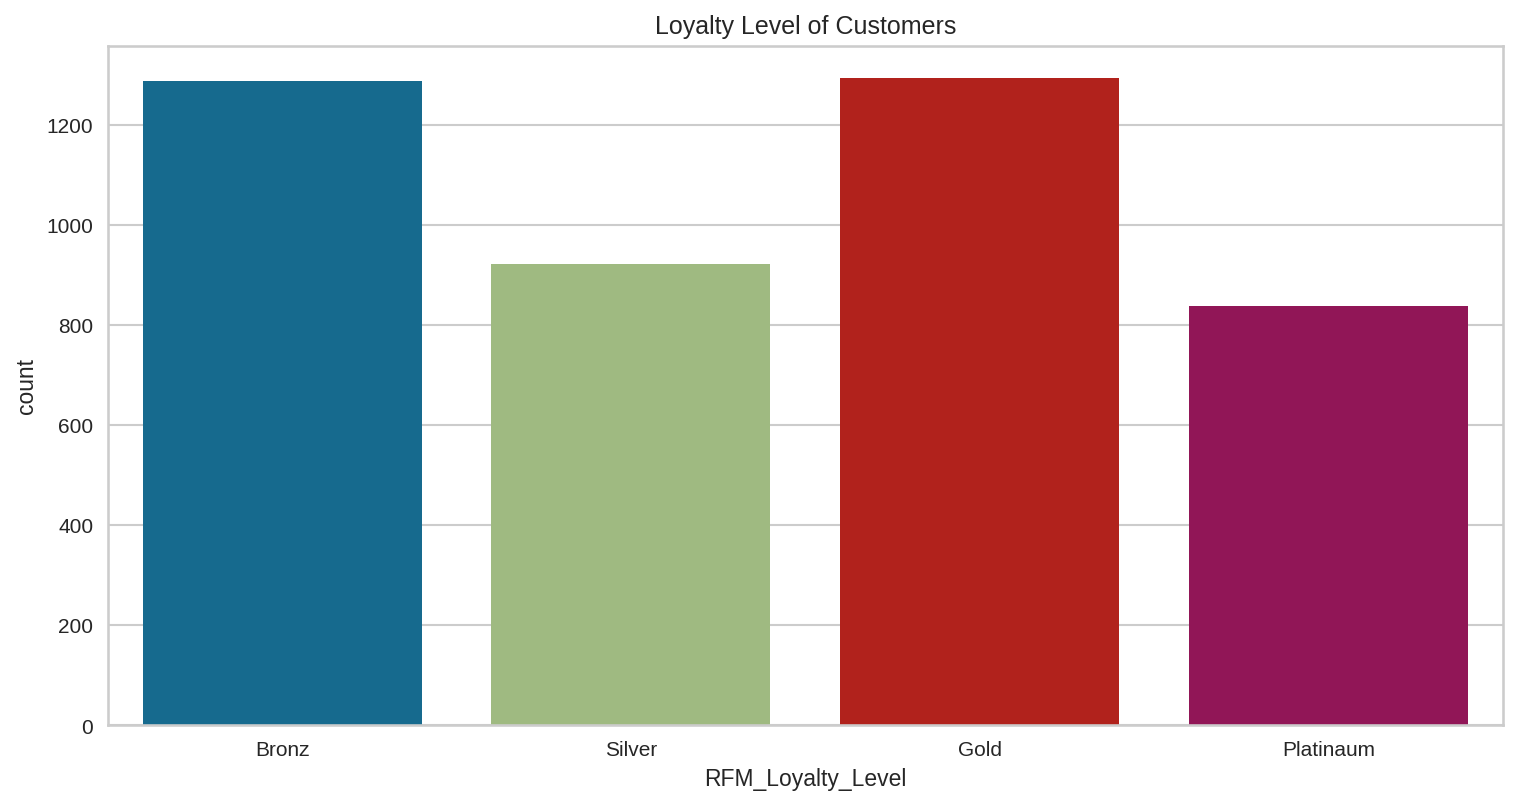

In [53]:
# Plot the loyelty level
plt.figure(figsize=(12,6))
sns.countplot(rfm_df['RFM_Loyalty_Level'])
plt.title('Loyalty Level of Customers')
plt.show()

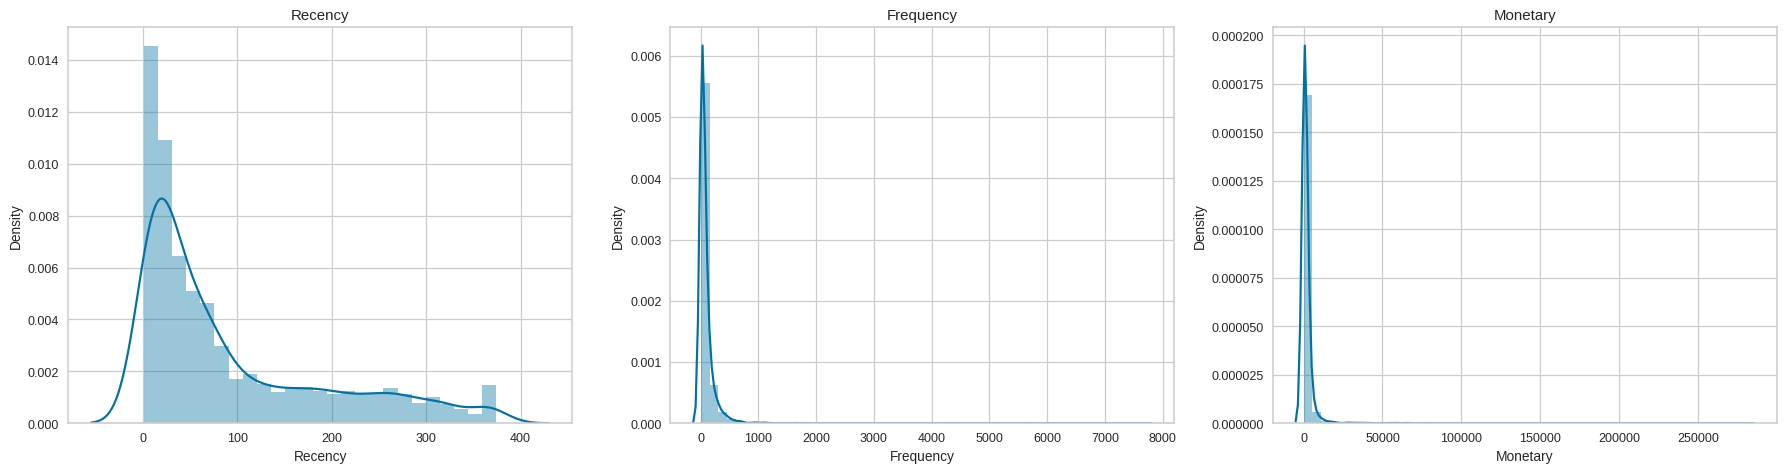

In [54]:
target = ['Recency', 'Frequency',	'Monetary']
plt.figure(figsize=(20,10), dpi=90)
for n,col in enumerate(target):
  plt.subplot(2, 3, n+1)
  sns.distplot(rfm_df[col])
  plt.title(col.title())
  plt.tight_layout()

Distributions of Recency, Frequency and Monetary columns are positively skewed\
This is indication of outliers

In [55]:
rfm_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.518322,90.512100,2048.215924
std,100.009747,225.515328,8984.248352
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,306.455000
50%,51.000000,41.000000,668.560000
75%,142.000000,98.000000,1660.315000
max,374.000000,7676.000000,280206.020000


In [56]:

rfm_df[rfm_df['Monetary'] == 0]

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Loyalty_Level
CustomerID,,,,,,,,,
13256.0,14,1,0.0,4,1,1,411,6,Silver


In [57]:
rfm_df[rfm_df['Recency'] == 0]

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Loyalty_Level
CustomerID,,,,,,,,,


In [58]:
rfm_df = rfm_df[rfm_df['Monetary'] > 0]

In [59]:
rfm_df

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Loyalty_Level
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6,Silver
12347.0,2,182,4310.00,4,4,4,444,12,Platinaum
12348.0,75,31,1797.24,2,2,4,224,8,Gold
12349.0,19,73,1757.55,3,3,4,334,10,Gold
12350.0,310,17,334.40,1,1,2,112,4,Bronz
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,Bronz
18281.0,181,7,80.82,1,1,1,111,3,Bronz
18282.0,8,12,178.05,4,1,1,411,6,Silver


In [60]:
data_rfm=rfm_df[['Recency','Frequency','Monetary']]

In [61]:
# Unskew the data
log_data = np.log(data_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(log_data)

# Scale and center the data
data_normalized = scaler.transform(log_data)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=log_data, index=data_rfm.index, columns=data_rfm.columns)

In [62]:
data_norm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.786897,0.000000,11.253942
12347.0,0.693147,5.204007,8.368693
12348.0,4.317488,3.433987,7.494007
12349.0,2.944439,4.290459,7.471676
12350.0,5.736572,2.833213,5.812338


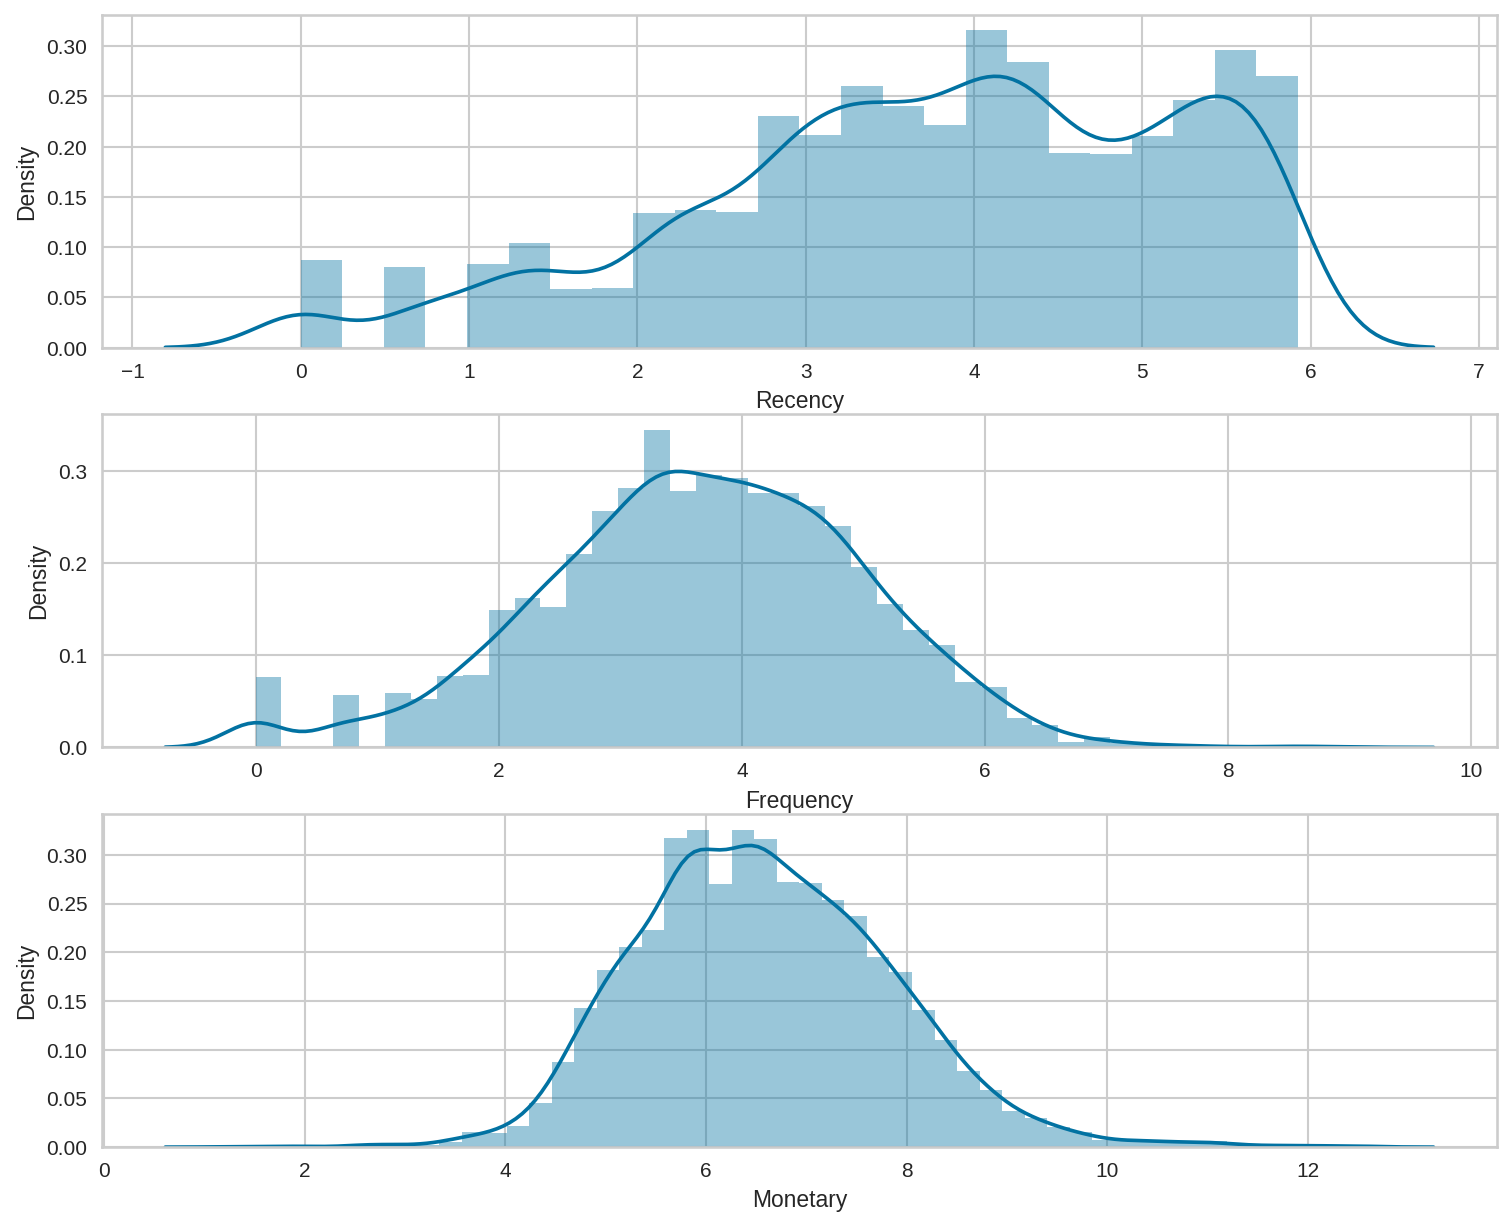

In [63]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['Monetary'])

# Show the plot
plt.show()

In [64]:

# Checking Descriptive Stats
rfm_df.describe()

,Recency,Frequency,Monetary,RFM_Score
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.536422,90.532734,2048.688081,7.502075
std,100.014169,225.537229,8985.230220,2.816683
min,1.000000,1.000000,3.750000,3.000000
25%,18.000000,17.000000,306.482500,5.000000
50%,51.000000,41.000000,668.570000,7.000000
75%,142.000000,98.000000,1660.597500,10.000000
max,374.000000,7676.000000,280206.020000,12.000000


**Model implementation:**

KMeans:

In [65]:
data_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [66]:
data_norm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.786897,0.000000,11.253942
12347.0,0.693147,5.204007,8.368693
12348.0,4.317488,3.433987,7.494007
12349.0,2.944439,4.290459,7.471676
12350.0,5.736572,2.833213,5.812338


In [67]:
# sse = {}

# # Fit KMeans and calculate SSE for each k
# for k in range(1, 21):
  
#     # Initialize KMeans with k clusters
#     kmeans = KMeans(n_clusters=k, random_state=1)
    
#     # Fit KMeans on the normalized dataset
#     kmeans.fit(data_norm)
    
#     # Assign sum of squared distances to k element of dictionary
#     sse[k] = kmeans.inertia_

In [68]:
# plt.figure(figsize=(12,8))

# plt.title('The Elbow Method')
# plt.xlabel('k'); 
# plt.ylabel('Sum of squared errors')
# sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
# plt.show()


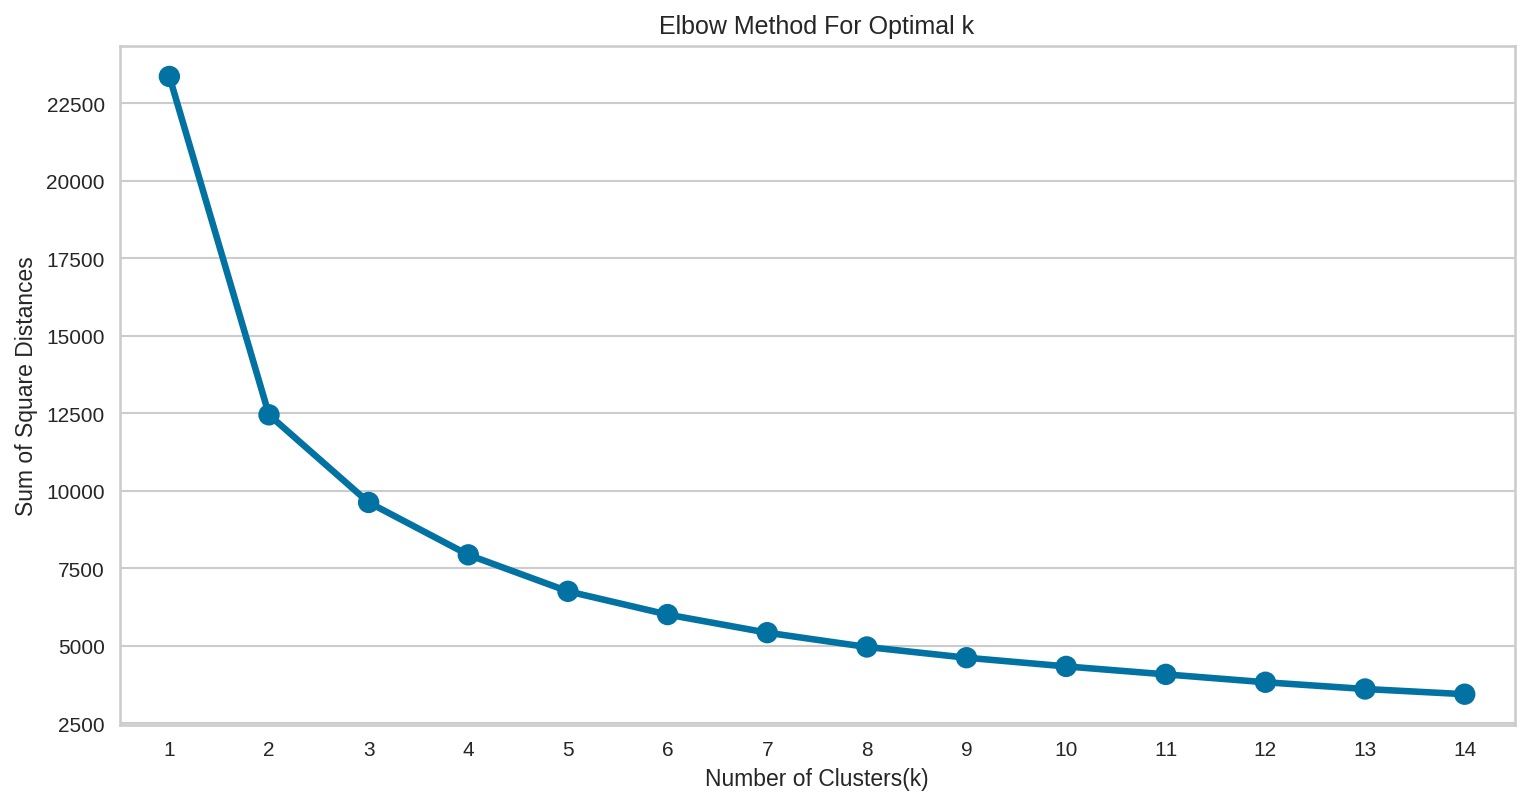

In [70]:
# taking Recency and Monetory_log in list.
RFM_feat=['Recency','Frequency','Monetary']

# taking only values of recency and monetory in X.
X=data_norm[RFM_feat].values

# # standardising the data
# scaler=StandardScaler()
# X=scaler.fit_transform(X)

#applying Elbow Method
wcss = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    wcss[k] = km.inertia_


#Plot the graph for the sum of square distance values and Number of Clusters
plt.figure(figsize=(12,6))
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

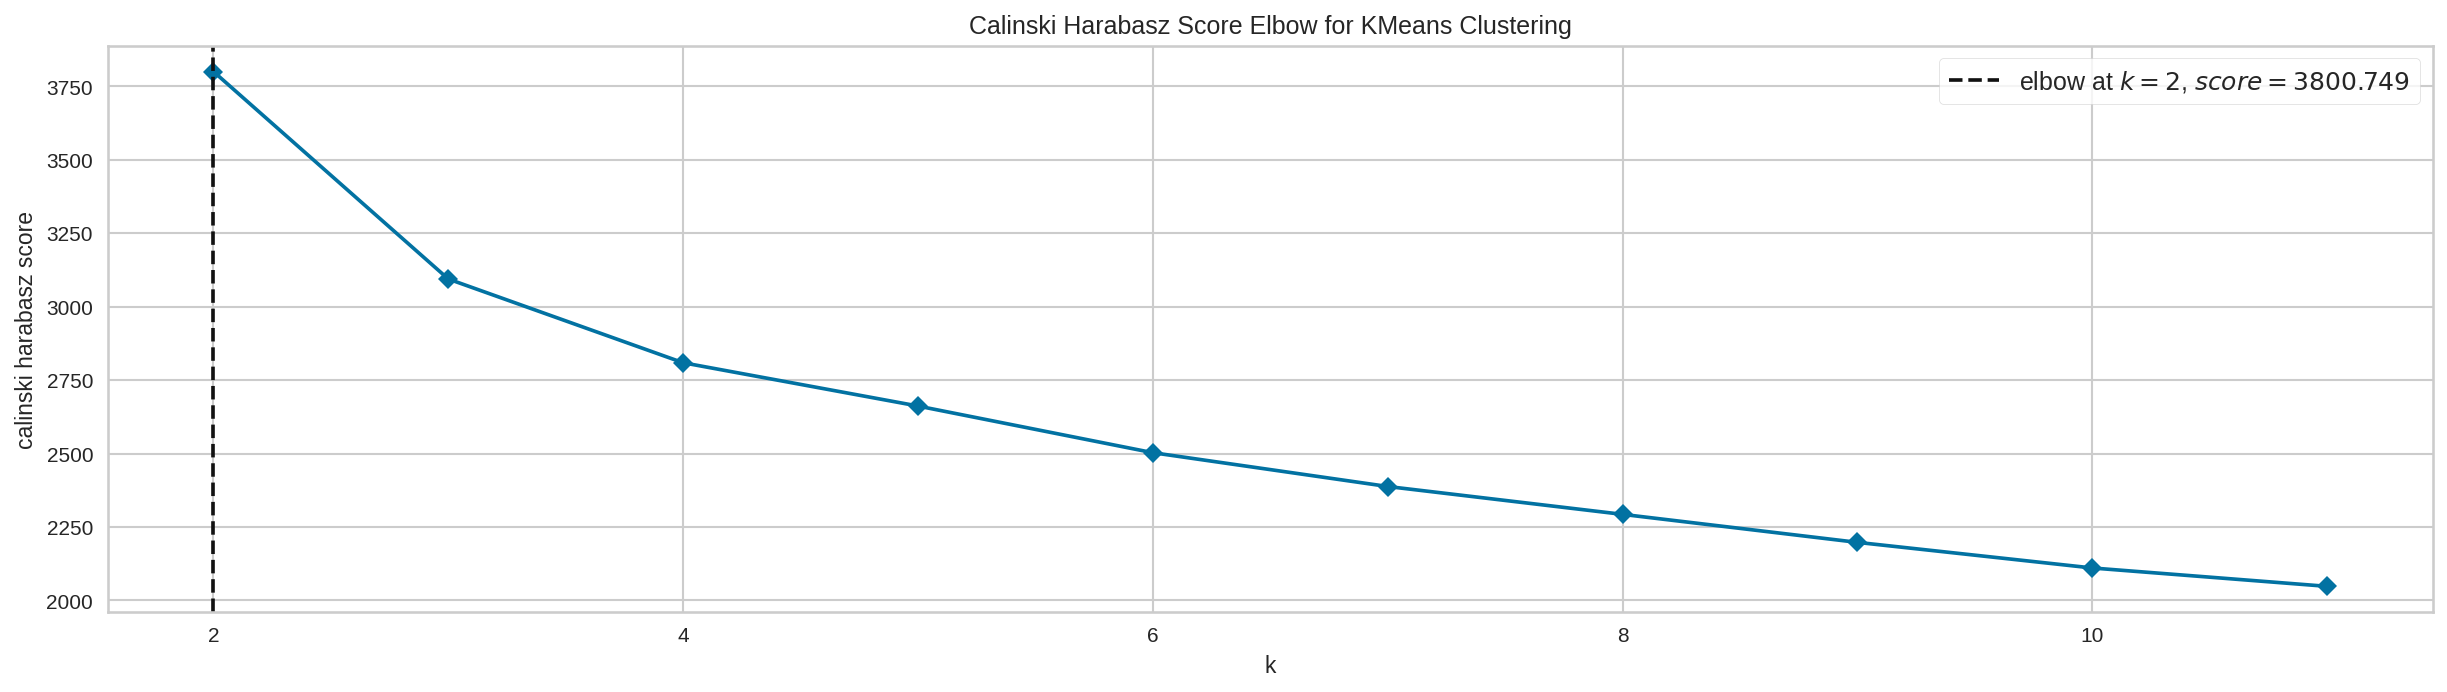

In [71]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [100]:
kmeans_2 = KMeans(n_clusters=2, random_state=1)


# Compute k-means clustering on pre-processed data
cluster_predict_2=kmeans_2.fit_predict(X)

# Extract cluster labels from labels_ attribute
cluster_labels_2 = kmeans_2.labels_

In [101]:
# Create a cluster label column in the original DataFrame
data_norm_k2 = data_norm.assign(Cluster = cluster_labels_2)
data_k2 = data_rfm.assign(Cluster = cluster_labels_2)

# Calculate average RFM values and size for each cluster
summary_k2 = data_k2.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

summary_k2

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         142.0      27.0    527.0  2486
1          27.0     176.0   4092.0  1852

In [102]:
def eval_metrics(data:pd.DataFrame,labels: np.array):
  """A function that calculates the evaluation metrics 
     for the unsupervised machine learning algorithm."""
  #A higher silhouette score is better  
  sh_score = silhouette_score(data,labels)

  #A higher calinski harabasz score is better
  ch_index = calinski_harabasz_score(data,labels)

  #A lower Davies Bouldin score is better
  db_score = davies_bouldin_score(data,labels)
  print('The evaluation metrics are:\n')
  print('1. The silhouette score is:',sh_score)
  print('\n2. The Calinski harabasz index is:',ch_index)
  print('\n3. The Davies Bouldin score is:',db_score)

In [103]:
#Calculating the evaluation metrics for the K-means model with 2 clusters
eval_metrics(X,cluster_predict_2)

The evaluation metrics are:

1. The silhouette score is: 0.3949255072270173

2. The Calinski harabasz index is: 3800.801753985666

3. The Davies Bouldin score is: 0.9554921743574956


In [109]:
kmeans_3 = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on pre-processed data
cluster_predict_3=kmeans_3.fit_predict(X)

# Extract cluster labels from labels_ attribute
cluster_labels_3 = kmeans_3.labels_

In [110]:
#  Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels_3)
data_k3 = data_rfm.assign(Cluster = cluster_labels_3)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

summary_k3

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          67.0      68.0   1238.0  1827
1         174.0      15.0    304.0  1538
2          11.0     251.0   6328.0   973

In [111]:
#Calculating the evaluation metrics for the K-means model with 3 clusters
eval_metrics(X,cluster_predict_3)

The evaluation metrics are:

1. The silhouette score is: 0.30254884142317157

2. The Calinski harabasz index is: 3094.345722191242

3. The Davies Bouldin score is: 1.1069084848516189


In [117]:
kmeans_4 = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
cluster_predict_4=kmeans_4.fit_predict(X)

# Extract cluster labels from labels_ attribute
cluster_labels_4 = kmeans.labels_

In [118]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels_4)
data_k4 = data_rfm.assign(Cluster = cluster_labels_4)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

summary_k4


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         187.0      15.0    303.0  1380
1          20.0      37.0    595.0   848
2          11.0     282.0   7169.0   827
3          91.0      84.0   1587.0  1283

In [119]:
#Calculating the evaluation metrics for the K-means model with 4 clusters
eval_metrics(X,cluster_predict_4)

The evaluation metrics are:

1. The silhouette score is: 0.30654289299720505

2. The Calinski harabasz index is: 2809.2305948664184

3. The Davies Bouldin score is: 1.0326731968197853


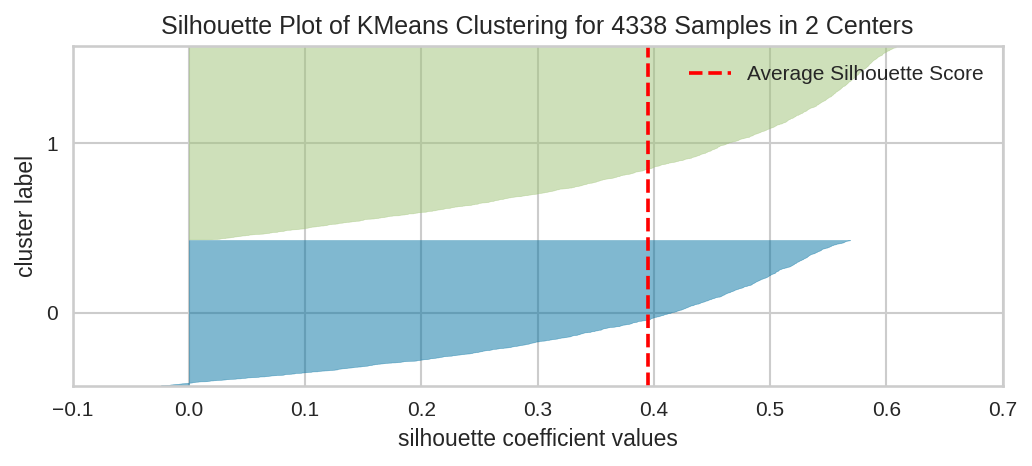

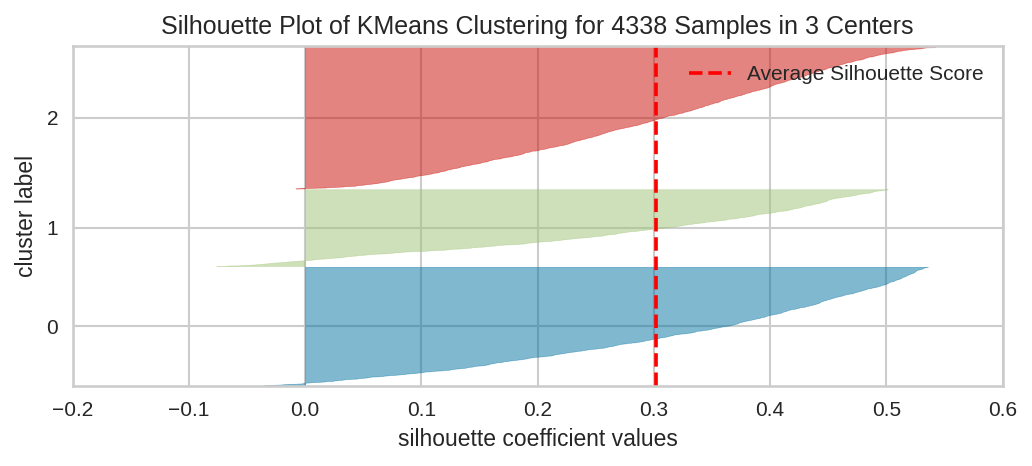

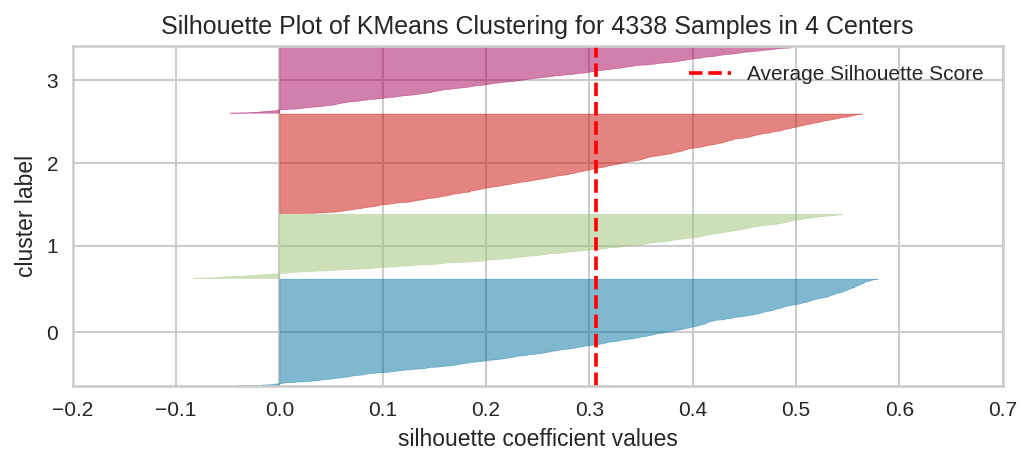

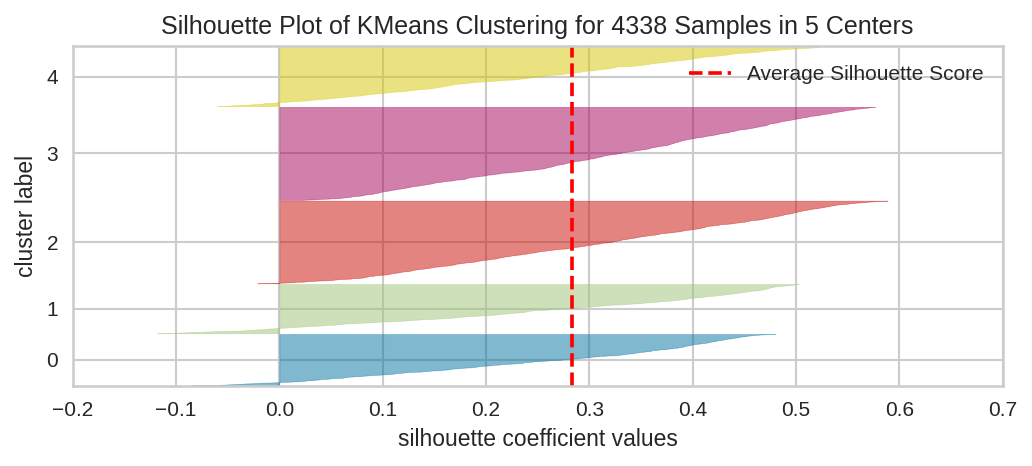

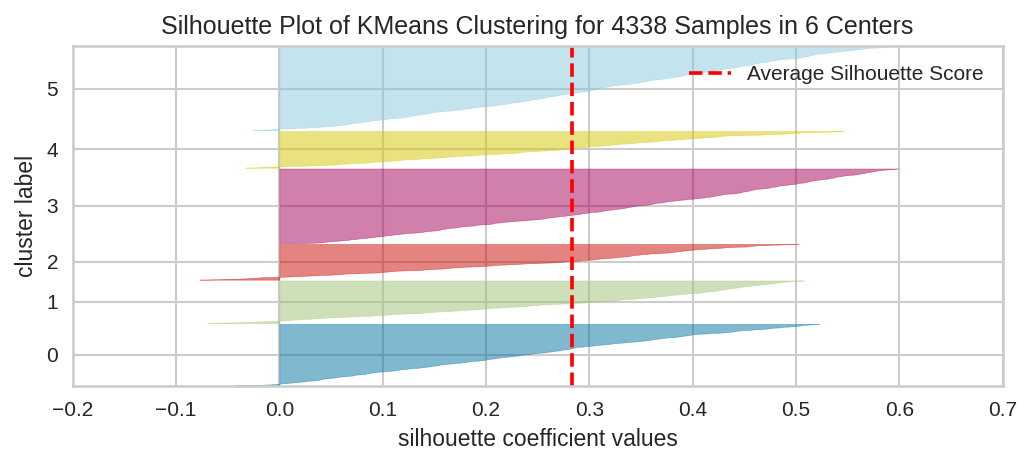

In [149]:
# Visualizing the Silouette plots for the clusters
for i in range(2,7):
    plt.figure(figsize = (8, 3), dpi=150)
    kmeans=KMeans(i,init="k-means++")
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show()

In [120]:
data_norm_k2.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,5.786897,0.000000,11.253942,0
12347.0,0.693147,5.204007,8.368693,1
12348.0,4.317488,3.433987,7.494007,0
12349.0,2.944439,4.290459,7.471676,1
12350.0,5.736572,2.833213,5.812338,0


In [121]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k2.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'],
                    var_name='Attribute',
                    value_name='Value')

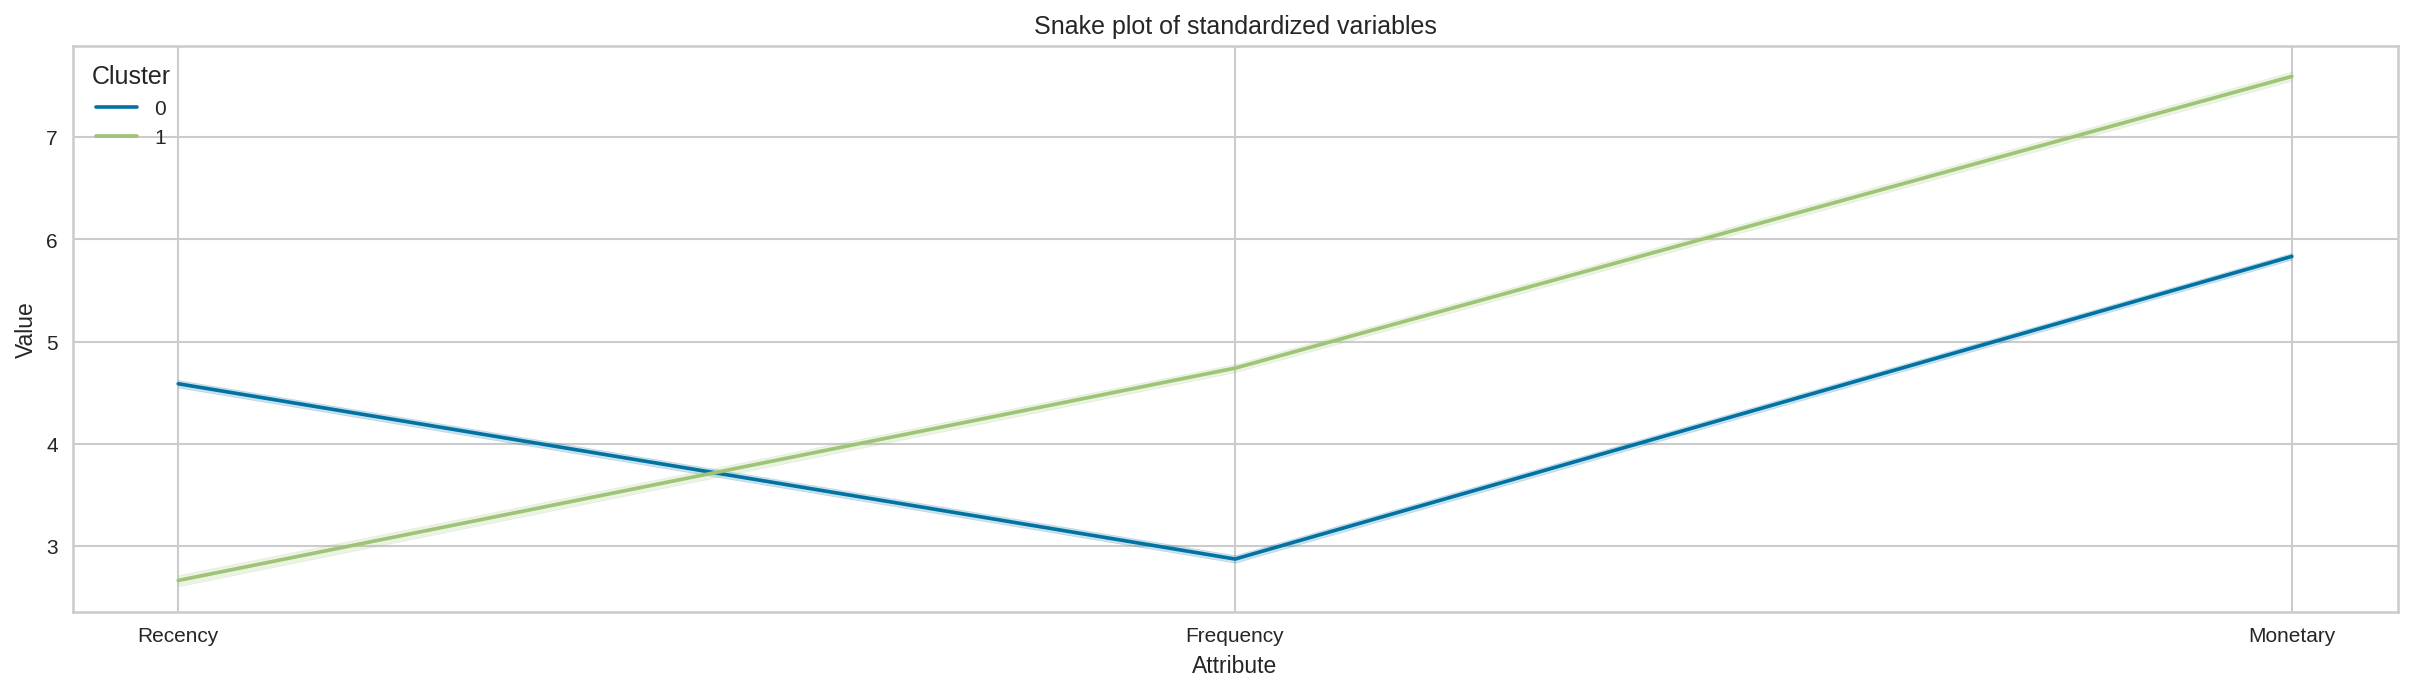

In [122]:

plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)

In [123]:
cluster_avg = data_k2.groupby(['Cluster']).mean()
cluster_avg 

,Recency,Frequency,Monetary
Cluster,,,
0,141.684232,26.524135,526.602873
1,26.563715,176.453564,4091.832695


In [124]:
population_avg = data_rfm.head().mean()
population_avg

Recency        146.400
Frequency       60.800
Monetary     17076.558
dtype: float64

In [125]:
relative_imp = cluster_avg / population_avg 
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,0.97,0.44,0.03
1,0.18,2.90,0.24


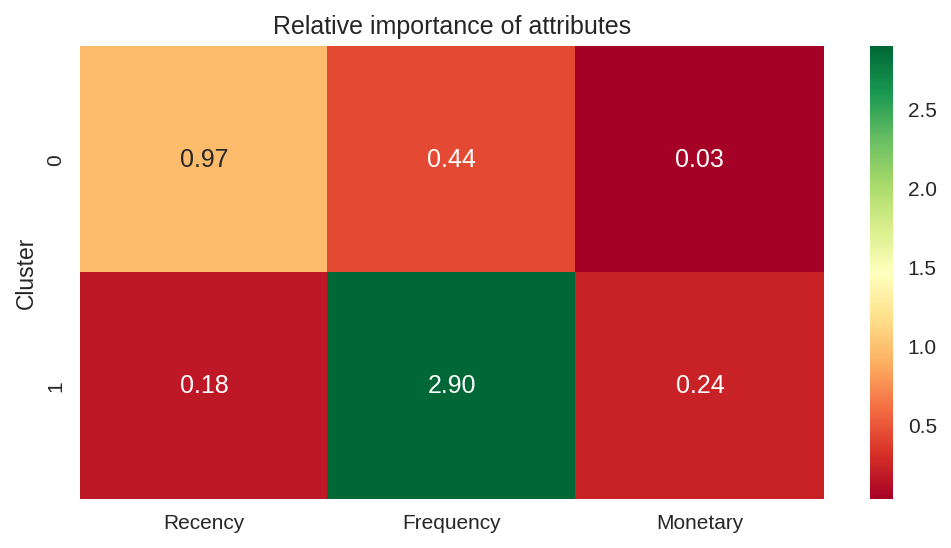

In [126]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Hierarchical clustering is another unsupervised machine learning algorithm, which is used to group the unlabeled datasets into a cluster and also known as hierarchical cluster analysis or HCA.

In this algorithm, we develop the hierarchy of clusters in the form of a tree, and this tree-shaped structure is known as the dendrogram.


In [129]:
import scipy.cluster.hierarchy as sch


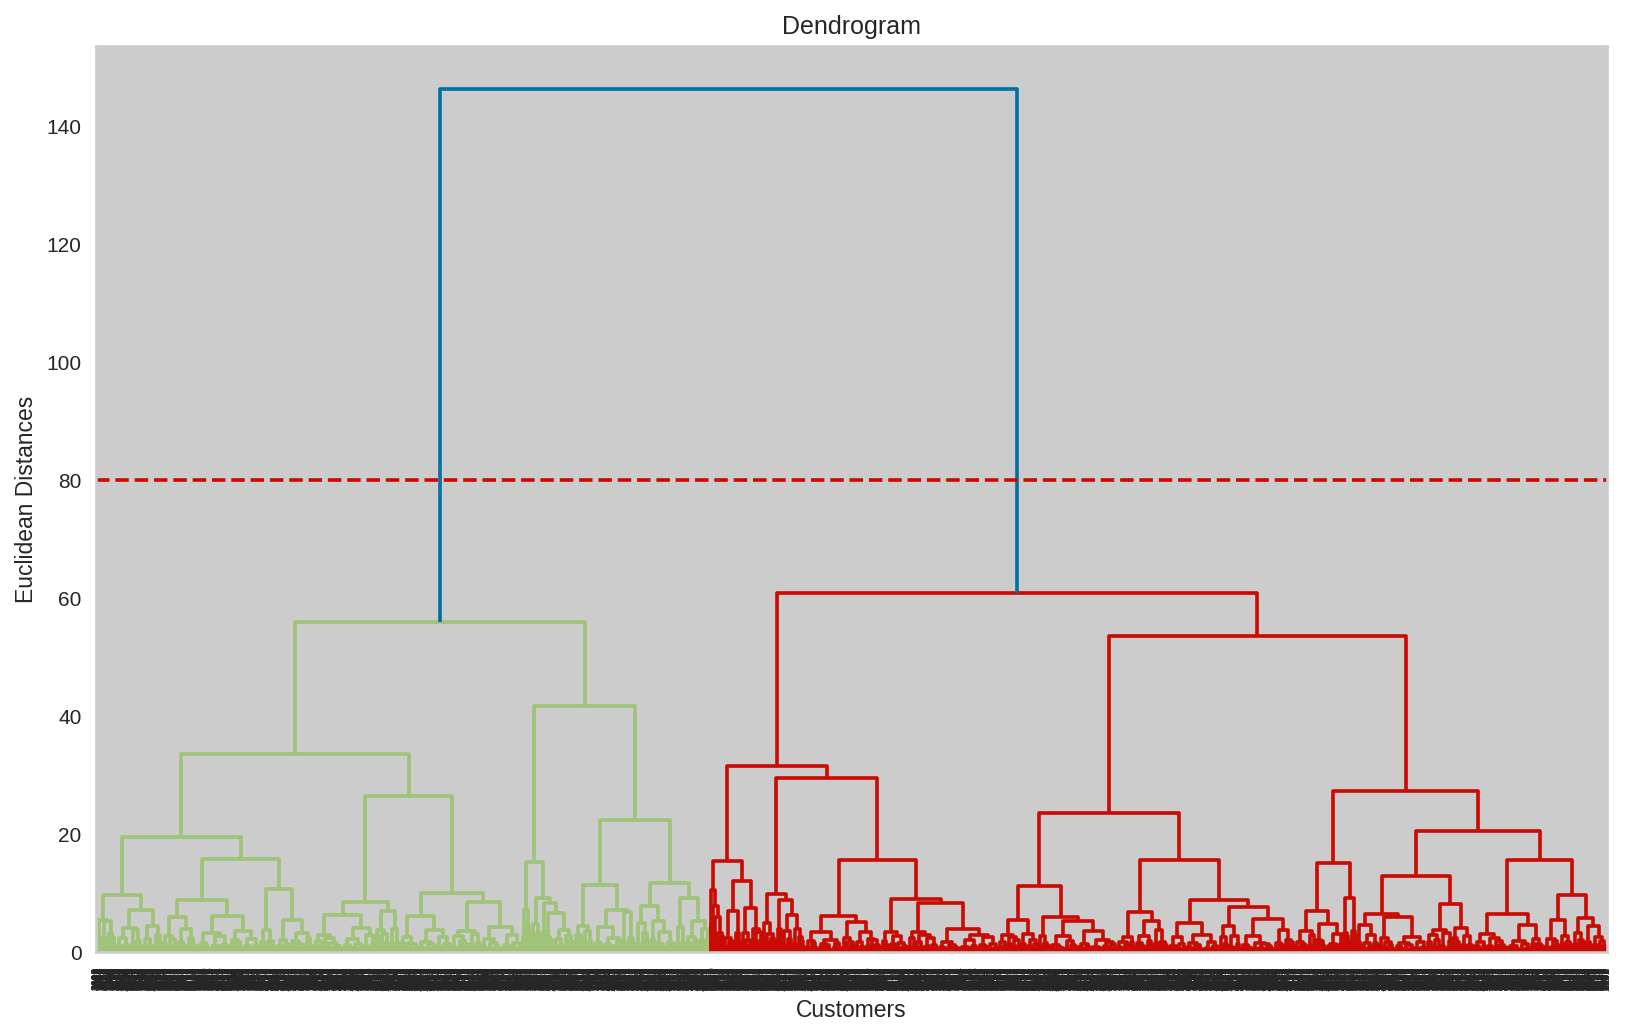

In [130]:
plt.figure(figsize=(13,8))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))

plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=80, color='r', linestyle='--')
plt.show() # find largest vertical distance we can make without crossing any other horizontal line

No. of Cluster = 2\
The number of clusters will be the number of vertical lines which are being intersected by the line drawn using the threshold.


In [131]:
#  Fitting hierarchical clustering to the mall dataset
from sklearn.cluster import AgglomerativeClustering
h_clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = h_clustering.fit_predict(X)

In [139]:
hc_labels=h_clustering.labels_

In [140]:
data_norm_hc = data_norm.assign(Cluster = hc_labels)
data_hc = data_rfm.assign(Cluster = hc_labels)

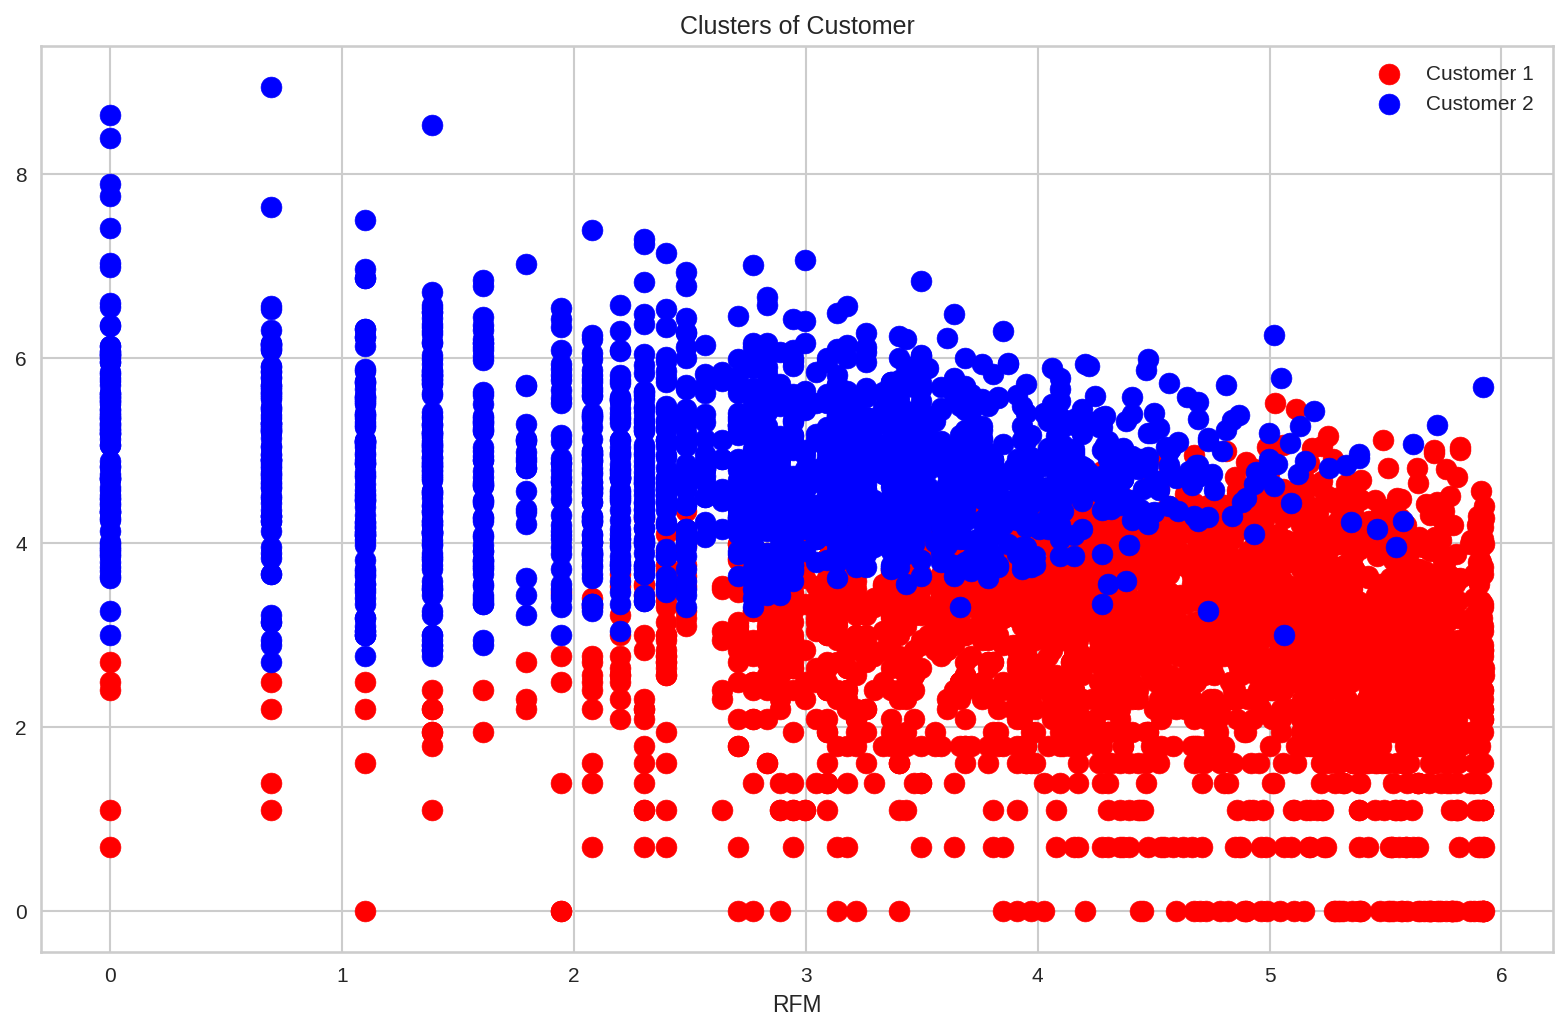

In [132]:
# Visualizing the clusters (two dimensions only)
plt.figure(figsize=(13,8))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Customer 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Customer 2')
#plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Target')

plt.title('Clusters of Customer')
plt.xlabel('RFM')

plt.legend()
plt.show()

In [133]:
data_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [141]:

# Calculate average RFM values and size for each cluster
summary_hc = data_hc.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

summary_hc

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         138.0      27.0    636.0  2574
1          26.0     183.0   4110.0  1764

DB SCAN

In [145]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [146]:
#eps value is the radius value for the datapoint from which circle is drwan and min sample indicates how many datapoints should be consider to consider that point in cluster.
#codesource(sklearn documentation)
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 336
Silhouette Coefficient: 0.153


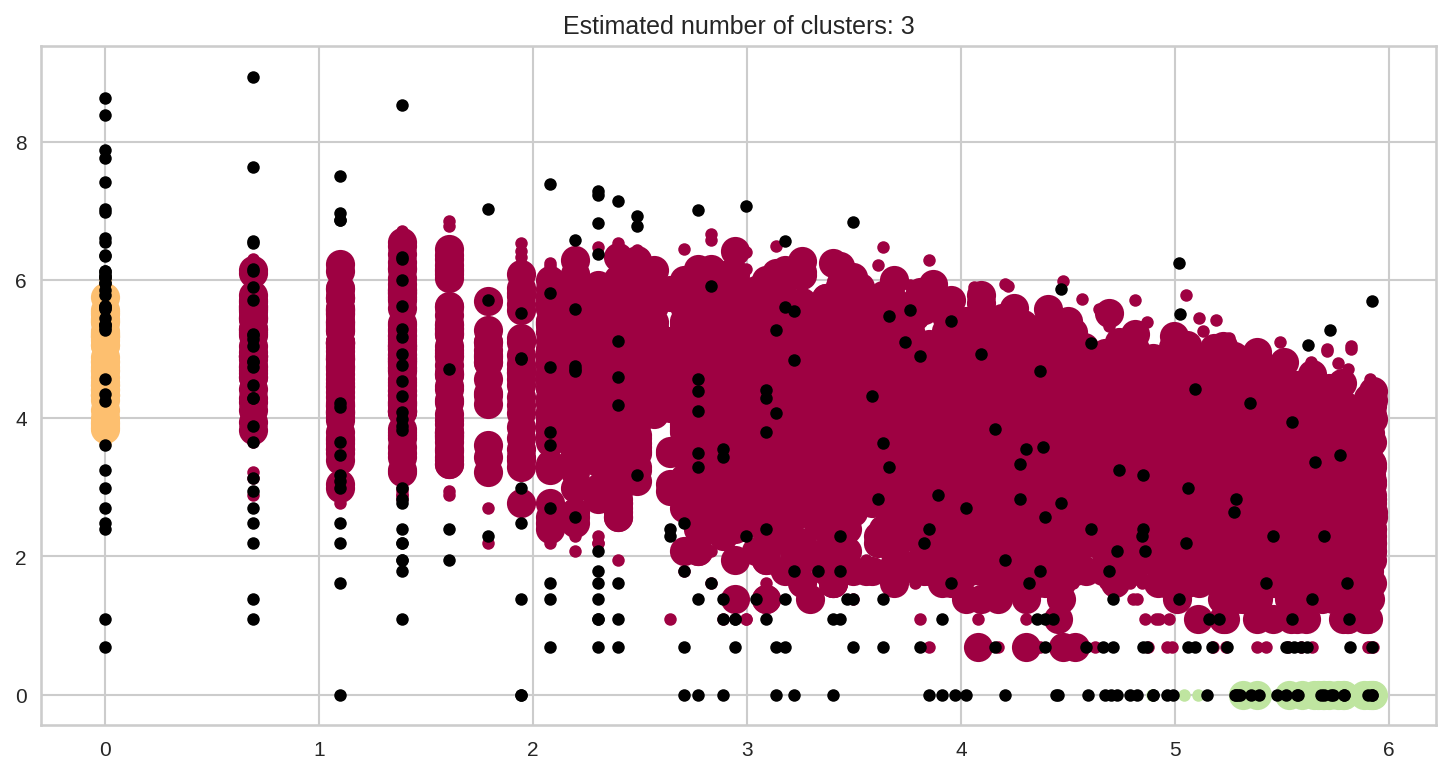

In [148]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(12,6))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k
    

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)

plt.show()